### **slope_models**

Run hierarchical models on project data:
- Test hypothesis (a), that in association cortices, the aperiodic slope flattens with age into young adulthood.
- Test hypothesis (b), that in sensorimotor cortices, the aperiodic slope flattens with age into adolescence.
- Test hypothesis (c), that regionally specific age effects differ between attentional states.

Author: EL Johnson, PhD

Copyright (c) 2022-2025  
ZR Cross, PhD & EL Johnson, PhD

### Set directories:

In [434]:
pth <- getwd() # navigate to directory containing folders of downloaded data
datdir <- paste(pth, 'Preprocessed_data', sep = '/')
savdir <- datdir # replace with your save path

### Load packages:  
If lme4 needs to be installed, run on the Anaconda command line:  
conda install -c conda-forge r-lme4

In [435]:
library(tidyverse)
library(RColorBrewer)
library(broom)
library(lme4)
library(splines)

### Load data:

In [436]:
dat_load <- paste(datdir, 'aperiodic_slope_models.csv', sep = '/')
average_df <- read.csv(dat_load) %>% 
  select(-X)

### Plot distribution of slopes:

Picking joint bandwidth of 0.122
Picking joint bandwidth of 0.109


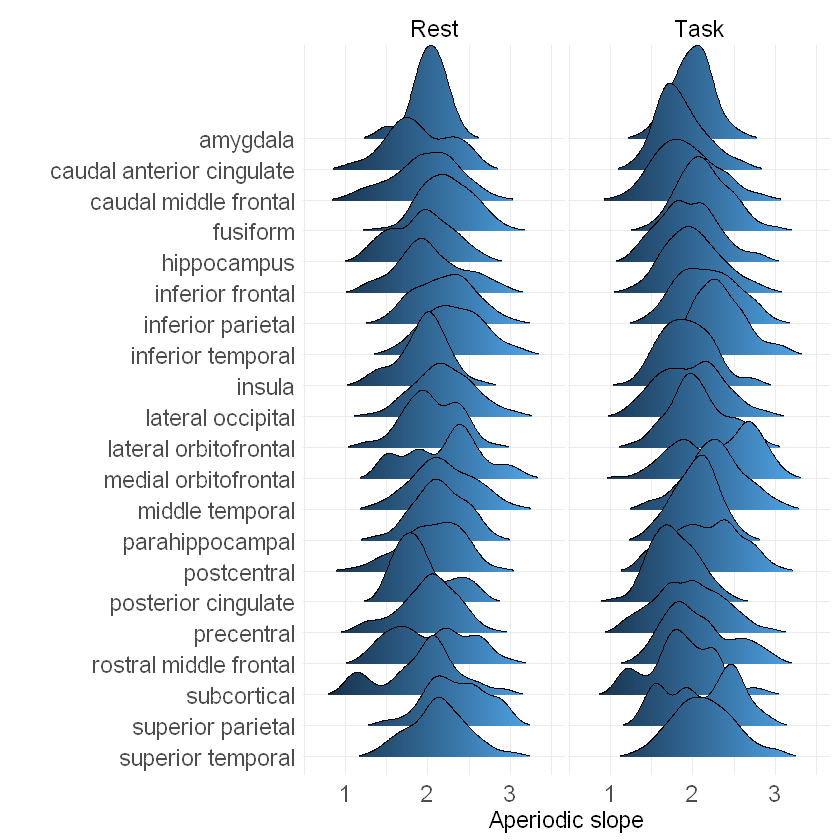

In [437]:
# convert DKT to factor with reverse alphabetical order
average_df$DKT <- factor(average_df$DKT, levels = rev(unique(average_df$DKT[order(average_df$DKT)])))

# plot with reverse alphabetically ordered DKT
ggplot(average_df, aes(x = Slope, y = DKT, fill = ..x..)) +
  geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01) +
  labs(y = '', x = 'Aperiodic slope') +
  facet_grid(~condition) +
  theme_minimal() +
  theme(
    panel.spacing = unit(0.1, 'lines'),
    strip.text.x = element_text(size = 14, colour = 'black'),
    strip.text.y = element_text(size = 14, colour = 'black'),
    legend.position = 'none',
    legend.spacing.x = unit(0.2, 'cm'),
    legend.key.size = unit(0.4, 'cm'),
    legend.background = element_rect(fill = alpha('blue', 0)),
    legend.text = element_text(size = 10, colour = 'black'),
    legend.title = element_text(size = 10, colour = 'black', face = 'bold'),
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 14),
    plot.title = element_text(size = 12, face = 'bold'))

### Get demographic data:

In [438]:
# get number of males/females by condition
sex_condition <- average_df %>%
  ungroup() %>% 
  select(subj, sex, age) %>%
  group_by(sex, subj) %>% 
  dplyr::summarise(age = mean(age)) %>% 
  dplyr::count(sex, sort = TRUE)

# make unique subjects a data frame
sid_list <- unique(average_df$subj)
sid_list <- as.data.frame(sid_list)

# check length of channels
length(unique(average_df$realID))

# get information for age
summary(average_df$age)

# remove subcortical bc not enough observations for model
average_df <- average_df %>% 
  filter(DKT != 'subcortical')

[1] 5691

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.937  13.101  16.667  19.254  26.000  54.000 

### Run model to test hypotheses (a) and (b):

In [439]:
large_df <- average_df %>%
      filter(DKT != 'amygdala' & DKT != 'hippocampus') %>%
      select(Slope, Offset, subj, DKT, age, realID) %>%
      mutate(Cortex = case_when(
          DKT %in% c('caudal middle frontal', 'insula', 'caudal anterior cingulate',
               'fusiform', 'inferior temporal', 'inferior parietal', 
               'superior temporal', 'middle temporal', 'parahippocampal', 
               'rostral middle frontal', 'posterior cingulate', 
               'superior parietal', 'medial orbitofrontal', 
               'inferior frontal', 'lateral orbitofrontal', 'temporal pole') ~ 'Association',
          DKT %in% c('postcentral', 'precentral', 'lateral occipital') ~ 'Sensorimotor',
          TRUE ~ NA_character_  # In case there are other regions not covered
      )) %>%
      group_by(subj, realID, Cortex, DKT) %>%
      dplyr::summarise(Slope = mean(Slope),
                       Offset = mean(Offset),
                       age = mean(age)) %>% 
      na.omit()

large_df$subj <- as.factor(large_df$subj)
large_df$realID <- as.factor(large_df$realID)
large_df$Cortex <- as.factor(large_df$Cortex)
large_df$DKT <- as.factor(large_df$DKT)

large_model_slope <- lmer(Slope ~ ns(age, df = 2) * Cortex + (1|subj) + (1|DKT), data = large_df, control = lmerControl(optimizer = 'bobyqa'))
summary(large_model_slope)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Slope ~ ns(age, df = 2) * Cortex + (1 | subj) + (1 | DKT)
   Data: large_df
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 1558.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8584 -0.6349 -0.0432  0.6045  3.6305 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.06548  0.2559  
 DKT      (Intercept) 0.01450  0.1204  
 Residual             0.08206  0.2865  
Number of obs: 3627, groups:  subj, 91; DKT, 18

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                            2.23480    0.08125  112.03263  27.505
ns(age, df = 2)1                      -0.36354    0.17928   91.31251  -2.028
ns(age, df = 2)2                       0.07848    0.13920   82.85408   0.564
CortexSensorimotor                     0.04978    0.09124   30.51812   0.546
ns(age, df = 2)1:Co

### Save large model:

In [440]:
dat_save <- paste(savdir, 'large_model_slope.RData', sep = '/')
save(large_model_slope, file = dat_save)

### Run model to test hypothesis (c):

In [441]:
# loop through DKT regions
run_lmm_and_extract_effects <- function(data) {
    data <- na.omit(data)  # filter out rows with missing values
    if (nrow(data) == 0) {
        cat('Skipping: no non-NA data available for this DKT region.\n')
        return(data.frame())  # return an empty data frame if no data
    }
    
    model <- lmer(Slope ~ age * condition + (1 | subj/realID) + (1|task), data = data, control = lmerControl(optimizer = 'bobyqa'))
    
    # extract fixed effects summary
    return(as.data.frame(summary(model)$coefficients))
}

### Create an empty list to populate with DKT labels:

In [442]:
DKT_levels <- unique(average_df$DKT)
combined_results <- data.frame()  # create an empty data frame for combined results
results_df_slope <- data.frame()  # create an empty data frame for results

### Apply lmer function to each DKT region:

In [443]:
for (level in DKT_levels) {
    cat('Processing DKT level:', level, '\n')  # print the current DKT level
    
    # subset the data
    subset_data <- average_df[average_df$DKT == level, ]
    
    # print the number of rows and a sample of the subset data for debugging
    cat('Number of rows in subset_data:', nrow(subset_data), '\n')
    print(head(subset_data))
    
    # check if there's enough data to run the model
    if (nrow(subset_data) < 5) {  # Threshold can be adjusted as needed
        cat('Skipping:', level, '- Not enough data.\n')
        next  # Skip this iteration if not enough data
    }
    
    # run lmer model and extract effects
    results <- run_lmm_and_extract_effects(subset_data)
    if (nrow(results) == 0) {
        cat('Skipping:', level, '- No results returned.\n')
        next  # skip if no results returned
    }
    
    # add the DKT level as a column in the results
    results$DKT <- level
    # append results to combined_results
    combined_results <- rbind(combined_results, results)
    
    # run lmer model for slope results
    model <- lmer(Slope ~ age * condition + (1 | subj/realID) + (1|task), data = subset_data, control = lmerControl(optimizer = 'bobyqa'))
    summary_model <- summary(model)
    
    # extract estimates, standard errors, and p-values for the fixed effects
    fixed_effects <- summary_model$coefficients[c(2, 3, 4), ]
    
    # create a new data frame to store the results for slope
    result_row <- data.frame(
        DKT = level,
        Estimate_Age = fixed_effects[1, 'Estimate'],
        SE_Age = fixed_effects[1, 'Std. Error'],
        PValue_Age = fixed_effects[1, 'Pr(>|t|)'],
        Estimate_Condition = fixed_effects[2, 'Estimate'],
        SE_Condition = fixed_effects[2, 'Std. Error'],
        PValue_Condition = fixed_effects[2, 'Pr(>|t|)'],
        Estimate_Interaction = fixed_effects[3, 'Estimate'],
        SE_Interaction = fixed_effects[3, 'Std. Error'],
        PValue_Interaction = fixed_effects[3, 'Pr(>|t|)']
    )
    
    # append the results to the main data frame for slope
    results_df_slope <- rbind(results_df_slope, result_row)
}

Processing DKT level: caudal middle frontal 
Number of rows in subset_data: 1372 
      subj       Channel               realID  task brodmann sex    Slope
1   CEMHDC CSC015-CSC016 CEMHDC_CSC015-CSC016  Rest      BA8   F 1.159067
2   CEMHDC CSC017-CSC018 CEMHDC_CSC017-CSC018  Rest      BA8   F 1.349323
3   CEMHDC CSC018-CSC019 CEMHDC_CSC018-CSC019  Rest      BA8   F 1.529040
8   CEMHDC CSC039-CSC040 CEMHDC_CSC039-CSC040  Rest      BA6   F 1.259162
108   CH15         A8-A7           CH15_A8-A7 Scene      BA6   F 1.518887
109   CH15         A8-A7           CH15_A8-A7  Rest      BA6   F 1.464415
      Offset      age       R.2 condition                   DKT
1   2.018942 28.00000 0.8068595      Rest caudal middle frontal
2   2.972559 28.00000 0.8415110      Rest caudal middle frontal
3   3.819627 28.00000 0.9022243      Rest caudal middle frontal
8   2.809807 28.00000 0.8238483      Rest caudal middle frontal
108 7.154309 10.13279 0.9601440      Task caudal middle frontal
109 6.991845 10.

boundary (singular) fit: see ?isSingular


Processing DKT level: insula 
Number of rows in subset_data: 180 
      subj       Channel               realID task    brodmann sex    Slope
4   CEMHDC CSC026-CSC027 CEMHDC_CSC026-CSC027 Rest Insula (13)   F       NA
9   CEMHDC CSC052-CSC053 CEMHDC_CSC052-CSC053 Rest Insula (13)   F 1.241722
664    DA7     LAI2-LAI3        DA7_LAI2-LAI3   WM Insula (13)   M       NA
665    DA7     LAI3-LAI4        DA7_LAI3-LAI4   WM Insula (13)   M       NA
666    DA7     LAI4-LAI5        DA7_LAI4-LAI5   WM Insula (13)   M       NA
667    DA7     LAI5-LAI6        DA7_LAI5-LAI6   WM Insula (13)   M       NA
      Offset age       R.2 condition    DKT Slope_no_outliers
4         NA  28 0.7565922      Rest insula                NA
9         NA  28 0.8115939      Rest insula          1.241722
664 6.829902  38 0.9032351      Task insula                NA
665 6.384782  38 0.9152520      Task insula                NA
666 6.488060  38 0.9227711      Task insula                NA
667 6.784948  38 0.8902128    

boundary (singular) fit: see ?isSingular


Processing DKT level: inferior temporal 
Number of rows in subset_data: 465 
      subj       Channel               realID  task brodmann sex    Slope
21  CEMHDC CSC114-CSC115 CEMHDC_CSC114-CSC115  Rest     BA20   F 1.918158
112   CH15        B11-B6          CH15_B11-B6 Scene     BA20   F 1.772056
113   CH15        B11-B6          CH15_B11-B6  Rest     BA20   F 1.764537
114   CH15        B12-B7          CH15_B12-B7 Scene     BA20   F 1.812504
115   CH15        B12-B7          CH15_B12-B7  Rest     BA20   F 1.827899
116   CH15        B13-B8          CH15_B13-B8 Scene     BA20   F 2.162041
      Offset      age       R.2 condition               DKT Slope_no_outliers
21  5.585045 28.00000 0.9263803      Rest inferior temporal          1.918158
112 7.331900 10.13279 0.9670360      Task inferior temporal          1.772056
113 7.298234 10.13279 0.9632638      Rest inferior temporal          1.764537
114 7.708122 10.13279 0.9704349      Task inferior temporal          1.812504
115 7.795596 10

boundary (singular) fit: see ?isSingular


Processing DKT level: lateral occipital 
Number of rows in subset_data: 464 
   subj Channel       realID  task brodmann sex    Slope   Offset      age
73 CH15 A42-A41 CH15_A42-A41 Scene     BA19   F 2.256295 9.168840 10.13279
74 CH15 A42-A41 CH15_A42-A41  Rest     BA19   F 2.175960 8.952896 10.13279
75 CH15 A43-A42 CH15_A43-A42 Scene     BA19   F 2.240219 9.397634 10.13279
76 CH15 A43-A42 CH15_A43-A42  Rest     BA19   F 2.118744 8.976493 10.13279
85 CH15 A50-A49 CH15_A50-A49 Scene     BA19   F 2.419126 9.204707 10.13279
86 CH15 A50-A49 CH15_A50-A49  Rest     BA19   F 2.394773 9.111270 10.13279
         R.2 condition               DKT Slope_no_outliers Offset_no_outliers
73 0.9891880      Task lateral occipital          2.256295           9.168840
74 0.9864808      Rest lateral occipital          2.175960           8.952896
75 0.9875619      Task lateral occipital          2.240219           9.397634
76 0.9861008      Rest lateral occipital          2.118744           8.976493
85 0.983

boundary (singular) fit: see ?isSingular


Processing DKT level: superior temporal 
Number of rows in subset_data: 505 
   subj Channel       realID  task          brodmann sex    Slope   Offset
81 CH15 A46-A45 CH15_A46-A45 Scene              BA22   F 1.911420 7.901076
82 CH15 A46-A45 CH15_A46-A45  Rest              BA22   F 1.738559 7.455470
83 CH15 A48-A47 CH15_A48-A47 Scene PrimAuditory (41)   F 1.693340 6.157522
84 CH15 A48-A47 CH15_A48-A47  Rest PrimAuditory (41)   F 1.797417 6.404554
95 CH15 A55-A54 CH15_A55-A54 Scene              BA22   F 2.070707 7.624686
96 CH15 A55-A54 CH15_A55-A54  Rest              BA22   F 2.151867 7.884504
        age       R.2 condition               DKT Slope_no_outliers
81 10.13279 0.9714627      Task superior temporal          1.911420
82 10.13279 0.9676330      Rest superior temporal          1.738559
83 10.13279 0.9509233      Task superior temporal          1.693340
84 10.13279 0.9462133      Rest superior temporal          1.797417
95 10.13279 0.9750400      Task superior temporal         

boundary (singular) fit: see ?isSingular


Processing DKT level: rostral middle frontal 
Number of rows in subset_data: 400 
    subj       Channel             realID task brodmann sex    Slope   Offset
142 CH16 RaCaS2-RaCaS3 CH16_RaCaS2-RaCaS3 Rest      BA9   M 1.869657 7.276326
143 CH16 RaCaS2-RaCaS3 CH16_RaCaS2-RaCaS3   WM      BA9   M 1.969679 7.512563
144 CH16 RaCaS3-RaCaS4 CH16_RaCaS3-RaCaS4 Rest      BA9   M 1.611393 4.827112
145 CH16 RaCaS3-RaCaS4 CH16_RaCaS3-RaCaS4   WM      BA9   M 1.704531 5.051645
182 CH16 RmOlF6-RmOlF7 CH16_RmOlF6-RmOlF7 Rest      BA9   M 1.598755 5.897165
183 CH16 RmOlF6-RmOlF7 CH16_RmOlF6-RmOlF7   WM      BA9   M 1.730032 6.231917
    age       R.2 condition                    DKT Slope_no_outliers
142  15 0.9007274      Rest rostral middle frontal          1.869657
143  15 0.9094415      Task rostral middle frontal          1.969679
144  15 0.8948359      Rest rostral middle frontal          1.611393
145  15 0.8993310      Task rostral middle frontal          1.704531
182  15 0.9173994      Rest

boundary (singular) fit: see ?isSingular


Processing DKT level: lateral orbitofrontal 
Number of rows in subset_data: 177 
    subj     Channel           realID  task brodmann sex    Slope    Offset age
420 CP26 RIHA1-RIHA2 CP26_RIHA1-RIHA2 Scene     BA11   M 2.705517 10.815502  26
421 CP26 RIHA1-RIHA2 CP26_RIHA1-RIHA2    WM     BA11   M 2.677479 10.717717  26
428 CP26   ROF1-ROF2   CP26_ROF1-ROF2 Scene     BA11   M 2.717085 11.027080  26
429 CP26   ROF1-ROF2   CP26_ROF1-ROF2    WM     BA11   M 2.612657 10.712677  26
686  DA7   LOF1-LOF2    DA7_LOF1-LOF2    WM     BA11   M 2.506860  6.321638  38
687  DA7   LOF2-LOF3    DA7_LOF2-LOF3    WM     BA11   M 2.727597  7.204801  38
          R.2 condition                   DKT Slope_no_outliers
420 0.9793358      Task lateral orbitofrontal          2.705517
421 0.9799304      Task lateral orbitofrontal          2.677479
428 0.9777944      Task lateral orbitofrontal          2.717085
429 0.9743890      Task lateral orbitofrontal          2.612657
686 0.8374841      Task lateral orbitof

### Generate table of results:

In [444]:
slope_table <- results_df_slope %>% 
    dplyr::rename(ROI = DKT, P_Age = PValue_Age, P_Condition = PValue_Condition, P_Interaction = PValue_Interaction)

### Apply FDR correction:

In [445]:
results_df_slope$p_age_corrected <- p.adjust(results_df_slope$PValue_Age, method = 'fdr')
results_df_slope$p_condition_corrected <- p.adjust(results_df_slope$PValue_Condition, method = 'fdr')
results_df_slope$p_interaction_corrected <- p.adjust(results_df_slope$PValue_Interaction, method = 'fdr')

### Save model results:

In [446]:
dat_save <- paste(savdir, 'results_df_slope.csv', sep = '/')
write.csv(results_df_slope, dat_save, row.names = FALSE)

### Plot age effects:

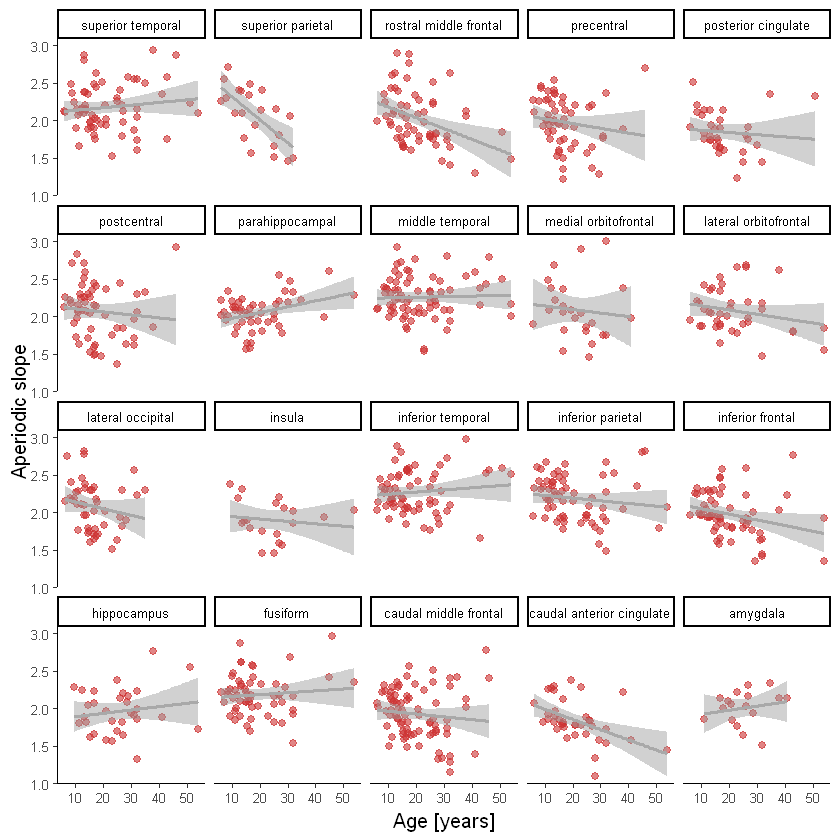

In [447]:
# age data frame for plotting
age_df <- average_df %>% 
    select(subj, DKT, Slope, age) %>% 
    group_by(subj, DKT) %>% 
    summarise(Slope = mean(Slope), age = mean(age))

# plot all DKT regions
ggplot(age_df, aes(x = age, y = Slope)) + 
      geom_point(color = 'brown3', alpha = 0.6, size = 2) +  # change to brick red
      geom_smooth(method = 'lm', linetype = 'solid', color = 'darkgray') +
      geom_ribbon(aes(ymin = ..ymin.., ymax = ..ymax..), stat = 'smooth', method = 'lm', fill = 'darkgray', alpha = 0.1) +
      scale_color_viridis_c(option = 'magma') +
      ylab('Aperiodic slope') + xlab ('Age [years]') +
      theme_classic() +
      facet_wrap(~DKT) +
      theme(legend.position = 'none',
            legend.spacing.x = unit(0.1, 'cm'),
            legend.key.size = unit(0.5, 'cm'),
            legend.background = element_rect(fill = alpha('blue', 0)),
            legend.text = element_text(size = 8, colour = 'black'),
            legend.title = element_text(size = 8, colour = 'black'),
            strip.text.x = element_text(size = 8, colour = 'black'),
            strip.text.y = element_text(size = 8, colour = 'black'),
            axis.text = element_text(size = 8),
            axis.title = element_text(size = 12),
            plot.title = element_text(size = 8, face = 'bold'))

### Plot age*attentional state effects:

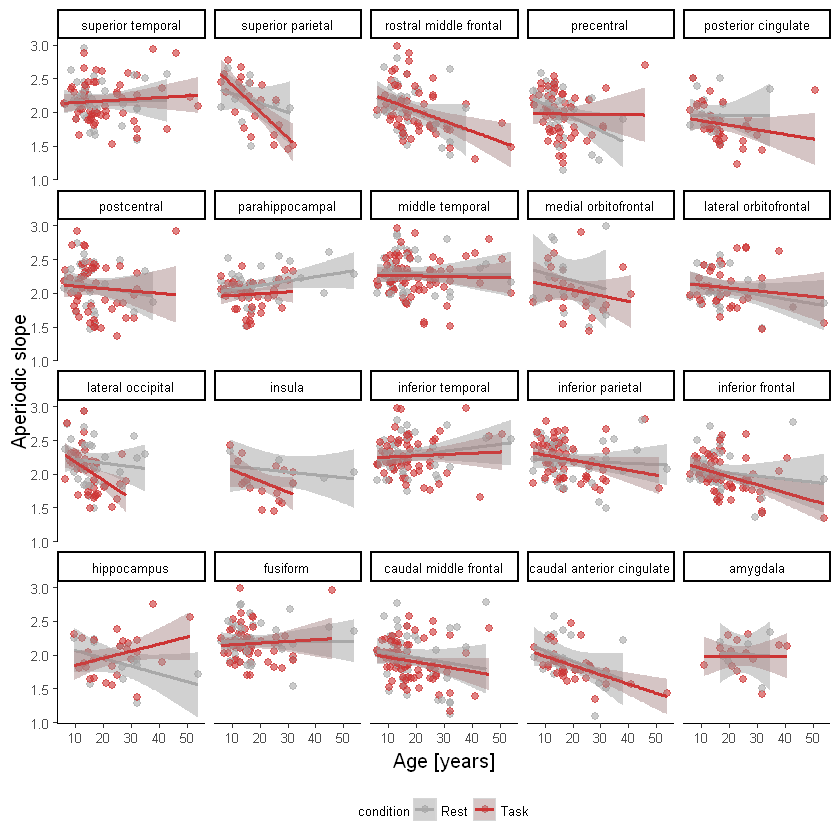

In [448]:
# age data frame for plotting - keep condition separate
age_df <- average_df %>%
    select(subj, DKT, Slope, age, condition) %>% 
    group_by(subj, DKT, condition) %>% 
    summarise(Slope = mean(Slope), age = mean(age), .groups = 'drop')

# plot all DKT regions with conditions
ggplot(age_df, aes(x = age, y = Slope, color = condition)) + 
    geom_point(alpha = 0.6, size = 2) +
    geom_smooth(method = 'lm', linetype = 'solid') +
    geom_ribbon(aes(ymin = ..ymin.., ymax = ..ymax.., fill = condition), stat = 'smooth', method = 'lm', alpha = 0.1, color = NA) +
    scale_color_manual(values = c('Task' = 'brown3', 'Rest' = 'darkgray')) +
    scale_fill_manual(values = c('Task' = 'brown3', 'Rest' = 'darkgray')) +
    ylab('Aperiodic slope') + xlab ('Age [years]') +
    theme_classic() +
        facet_wrap(~DKT) +
        theme(legend.position = 'bottom',
        legend.spacing.x = unit(0.1, 'cm'),
        legend.key.size = unit(0.5, 'cm'),
        legend.background = element_rect(fill = alpha('blue', 0)),
        legend.text = element_text(size = 8, colour = 'black'),
        legend.title = element_text(size = 8, colour = 'black'),
        strip.text.x = element_text(size = 8, colour = 'black'),
        strip.text.y = element_text(size = 8, colour = 'black'),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 12),
        plot.title = element_text(size = 8, face = 'bold'))